# Transfer Learning for Image Classification:

### 1. Import Libraries and Load Data:

#### 1.1 Import Libraries:

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#### 1.2 Define utils functions:

In [2]:
# Display a batch of augmented images
def show_batch(dataset, MEAN = 0, STD = 1):
    plt.figure(figsize=(10, 10))
    dataset_it = iter(dataset)
    for i in range(9):
        images, labels = dataset_it.get_next()
        plt.subplot(3, 3, i + 1)
        plt.imshow((images.numpy() * STD + MEAN))  # De-normalize for visualization
        plt.axis("off")
    plt.show()

#### 1.3 Load the data:

In [3]:
dataset_name = "oxford_flowers102"
(train_ds, val_ds, test_ds), dataset_info = tfds.load(
    dataset_name, 
    split=["train", "validation", "test"], 
    as_supervised=True,  # Returns (image, label) pairs
    with_info=True       # Provides dataset metadata
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.FW3PDQ_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.FW3PDQ_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.FW3PDQ_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [4]:
# Print dataset info
print(dataset_info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

There is no need to split the training, val, testing dataset manually, tensorflow split it for us by 75% train and 12.5% for each val and test

#### 1.4 Show sample of images:

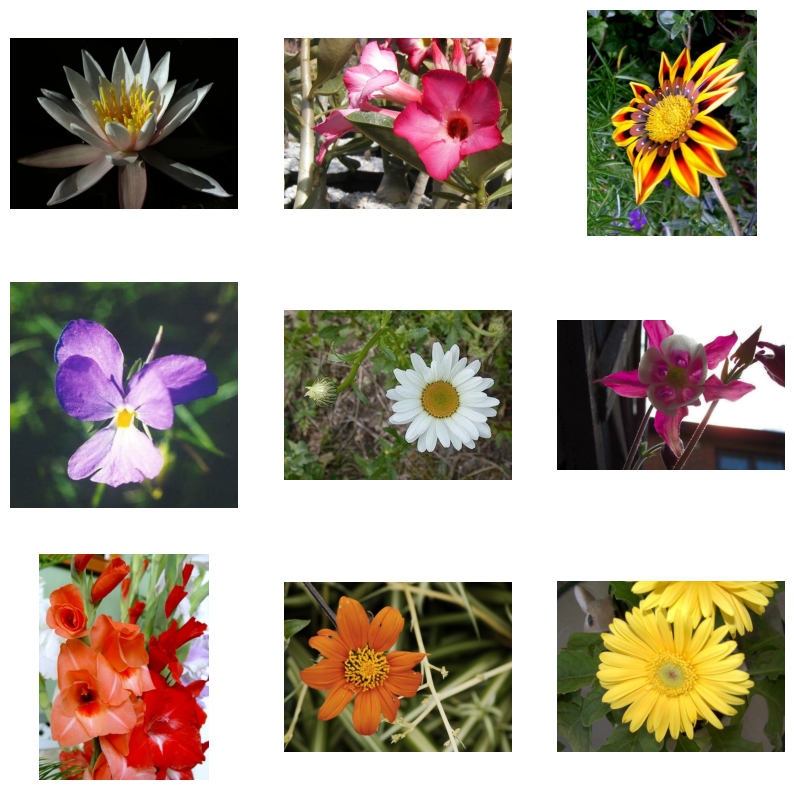

In [5]:
show_batch(train_ds)

### 2. Prepare Images for Training:

### 2.1 Normalization and Data Augmentation:

In [6]:
# Normalization values (computed from ImageNet dataset)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

We will normalize our dataset with ImageNet mean and STD, because we will fine tunning VGG16 that pretrained using ImageNet, and We need to avoid distrbution shift.

In [7]:
# Data augmentation function
def augment(image, label):
    image = tf.image.resize(image, (256, 256))  # Resize to a larger size for cropping
    # Crop the images to 224x224 because VGG16 Input layer expect 224x224 image.
    image = tf.image.random_crop(image, size=[224, 224, 3])  # Random crop to 224x224
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random 90-degree rotation

    return image, label

# Apply only normalization (no augmentation)
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize
    image = (image / 255.0 - MEAN) / STD  # Normalize
    return image, label


In [8]:
train_ds = train_ds.map(preprocess)

# Apply augmentation to training dataset
augmented_train_ds = train_ds.map(augment)
# Combine original and augmented datasets
expanded_train_ds = train_ds.concatenate(augmented_train_ds)

# Shuffle the dataset to avoid place similar photos beside each others
train_ds = expanded_train_ds.shuffle(2000)

# Only normalizition
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

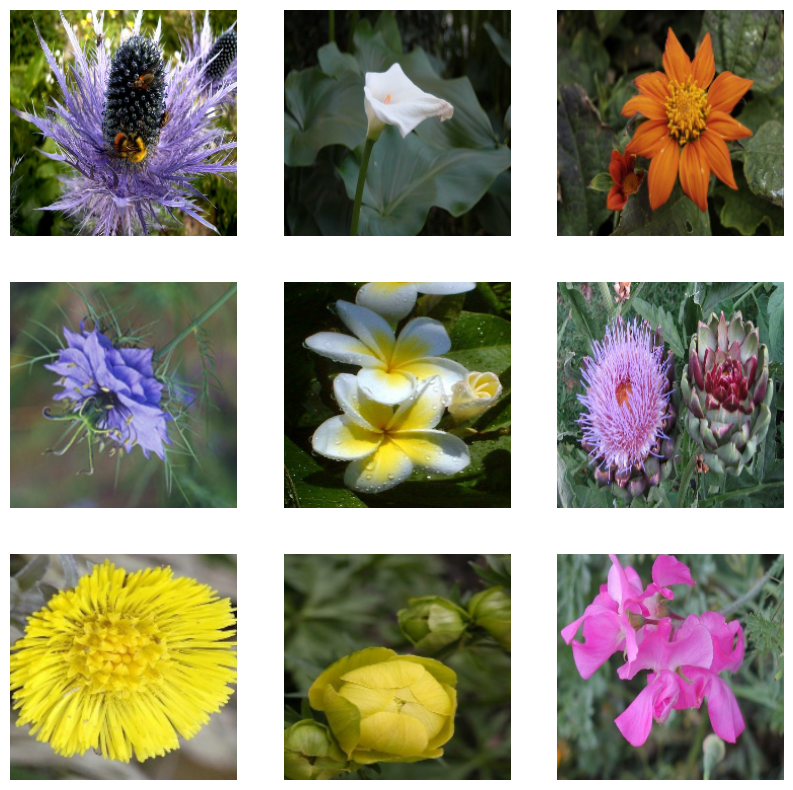

In [9]:
show_batch(train_ds, MEAN, STD)

#### 2.2 Batch the dataset:

In [10]:
BATCH_SIZE = 64
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

### 3. Training a classification model:

#### 3.1 Load VGG16 model pretrained on ImageNet dataset:

In [11]:
# Load VGG16 with pretrained ImageNet weights, excluding top FC layers.
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers.
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 3.2 Build the model:

In [12]:
# Build the new model
model = models.Sequential([
    base_model,
    layers.Flatten(),  # Flatten convolutional output
    layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(102, activation="softmax")  # 102 classes for Oxford Flowers
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 102)                 │          26,214 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,717,798 (105.74 MB)

 Trainable params: 13,003,110 (49.60 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### 3.3 Define Callbacks for learning rate scheduling and early stopping to optimize training:

In [13]:
# Reduce learning rate when validation loss plateaus
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

In [14]:
# Stop training if validation loss doesn't improve for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)

#### 3.4 Run the training on both GPUs on Kaggle (I am using GPU T4 x2):

In [15]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 2


In [16]:
# Enable multi-GPU training
strategy = tf.distribute.MirroredStrategy()

print(f"Using {strategy.num_replicas_in_sync} GPUs")

Using 2 GPUs


In [17]:
with strategy.scope():
    # Load VGG16 Pretrained Model
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model

    # Build Custom Model
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),  # Prevent overfitting
        layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(102, activation="softmax")  # 102 classes for Oxford Flowers
    ])

    # Compile Model (Automatically Optimized for Multi-GPU)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [18]:
# Train on 2 GPUs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Set a high number, early stopping will stop automatically
    callbacks=[lr_callback, early_stopping]
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 622ms/step - accuracy: 0.0110 - loss: 15.2314 - val_accuracy: 0.0547 - val_loss: 9.2704 - learning_rate: 0.0010
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 416ms/step - accuracy: 0.0483 - loss: 8.4119 - val_accuracy: 0.1504 - val_loss: 6.5607 - learning_rate: 0.0010
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 430ms/step - accuracy: 0.1072 - loss: 6.1774 - val_accuracy: 0.2363 - val_loss: 5.2173 - learning_rate: 0.0010
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 436ms/step - accuracy: 0.1357 - loss: 5.2697 - val_accuracy: 0.3145 - val_loss: 4.5290 - learning_rate: 0.0010
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.1669 - loss: 4.6844 - val_accuracy: 0.3340 - val_loss: 4.1676 - learning_rate: 0.0010
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 433ms/step - accuracy: 0.2391 - loss: 4.1615 - val_accuracy: 0.4062 - val_loss: 3.8231 - learning_rate: 0.0010
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 479ms/step - accuracy: 0.2597 - loss: 3

In [19]:
# Train on 2 GPUs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Set a high number, early stopping will stop automatically
    callbacks=[lr_callback, early_stopping]
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 490ms/step - accuracy: 0.5842 - loss: 2.2029 - val_accuracy: 0.6426 - val_loss: 2.1724 - learning_rate: 5.0000e-04
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - accuracy: 0.5783 - loss: 2.2391 - val_accuracy: 0.6543 - val_loss: 2.1582 - learning_rate: 5.0000e-04
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - accuracy: 0.5788 - loss: 2.2190 - val_accuracy: 0.6504 - val_loss: 2.1234 - learning_rate: 5.0000e-04
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.6072 - loss: 2.1420 - val_accuracy: 0.6621 - val_loss: 2.1220 - learning_rate: 5.0000e-04
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 492ms/step - accuracy: 0.5943 - loss: 2.1833 - val_accuracy: 0.6699 - val_loss: 2.1327 - learning_rate: 5.0000e-04
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.5935 - loss: 2.1475 - val_accuracy: 0.6602 - val_loss: 2.0366 - learning_rate: 5.0000e-04
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - acc

In [20]:
# Train on 2 GPUs
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Set a high number, early stopping will stop automatically
    callbacks=[lr_callback, early_stopping]
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step - accuracy: 0.6705 - loss: 1.6902 - val_accuracy: 0.6992 - val_loss: 1.7778 - learning_rate: 1.2500e-04
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - accuracy: 0.6934 - loss: 1.6533 - val_accuracy: 0.6934 - val_loss: 1.7748 - learning_rate: 1.2500e-04
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.6938 - loss: 1.6498 - val_accuracy: 0.7051 - val_loss: 1.7643 - learning_rate: 1.2500e-04
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 487ms/step - accuracy: 0.6812 - loss: 1.6859 - val_accuracy: 0.6934 - val_loss: 1.7745 - learning_rate: 1.2500e-04
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - accuracy: 0.6951 - loss: 1.6397 - val_accuracy: 0.6855 - val_loss: 1.7696 - learning_rate: 1.2500e-04
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - accuracy: 0.7042 - loss: 1.6644 - val_accuracy: 0.7148 - val_loss: 1.7523 - learning_rate: 1.2500e-04
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 511ms/step - acc

#### 3.5 Fine Tune last 4 layers of VGG16:

In [21]:
with strategy.scope():
    # Unfreeze only the last 2 convolutional layers for fine-tuning
    for layer in base_model.layers[-2:]:  # Reduce from 4 to 2 for stability
        layer.trainable = True

    # Lower learning rate for fine-tuning
    fine_tune_lr = 5e-6  # Reduce even further to avoid damaging features

    # Learning Rate Scheduling (Exponential Decay)
    fine_tune_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=fine_tune_lr, decay_steps=500, decay_rate=0.9, staircase=True
    )

    # Optimizer with LR scheduling
    optimizer = tf.keras.optimizers.Adam(learning_rate=fine_tune_lr_schedule)

    # **Recompile the model after unfreezing layers**
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [22]:
# Stop training early if no improvement (Reduced the patience from 5 to 3)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)

In [23]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Fine-tuning requires fewer epochs
    callbacks=[early_stopping]
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 518ms/step - accuracy: 0.7004 - loss: 1.5876 - val_accuracy: 0.7207 - val_loss: 1.6734
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 511ms/step - accuracy: 0.7095 - loss: 1.5535 - val_accuracy: 0.7246 - val_loss: 1.6626
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - accuracy: 0.6974 - loss: 1.5823 - val_accuracy: 0.7207 - val_loss: 1.6522
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - accuracy: 0.7186 - loss: 1.5634 - val_accuracy: 0.7285 - val_loss: 1.6554
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.7357 - loss: 1.5043 - val_accuracy: 0.7207 - val_loss: 1.6462
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step - accuracy: 0.7132 - loss: 1.5532 - val_accuracy: 0.7305 - val_loss: 1.6417
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 509ms/step - accuracy: 0.7042 - loss: 1.5492 - val_accuracy: 0.7207 - val_loss: 1.6478
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 512ms/step - accuracy: 0.7367 - loss: 1.4592 - val_accu

In [24]:
history_finetune2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Fine-tuning requires fewer epochs
    callbacks=[early_stopping]
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.7070 - loss: 1.5269 - val_accuracy: 0.7246 - val_loss: 1.6262
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.7253 - loss: 1.4922 - val_accuracy: 0.7383 - val_loss: 1.6131
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 513ms/step - accuracy: 0.7105 - loss: 1.4893 - val_accuracy: 0.7285 - val_loss: 1.6126
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 524ms/step - accuracy: 0.7438 - loss: 1.4146 - val_accuracy: 0.7305 - val_loss: 1.6252
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 507ms/step - accuracy: 0.7196 - loss: 1.4728 - val_accuracy: 0.7266 - val_loss: 1.6095
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.7257 - loss: 1.4697 - val_accuracy: 0.7266 - val_loss: 1.6075
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.7237 - loss: 1.4540 - val_accuracy: 0.7285 - val_loss: 1.6015
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.7292 - loss: 1.4334 - val_accu

#### 3.6 Visualiztion:

In [25]:
# Function to plot loss and accuracy curves
def plot_training_curves(history):
    # Get training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label="Training Loss")
    plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    plt.show()

#### 3.7 Training curves:

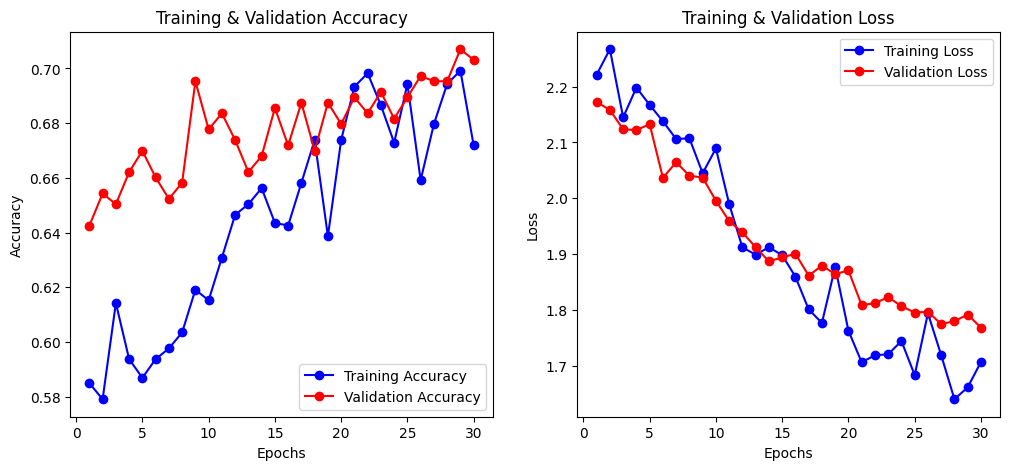

In [26]:
plot_training_curves(history)

#### 3.8 Fine Tunning curves:

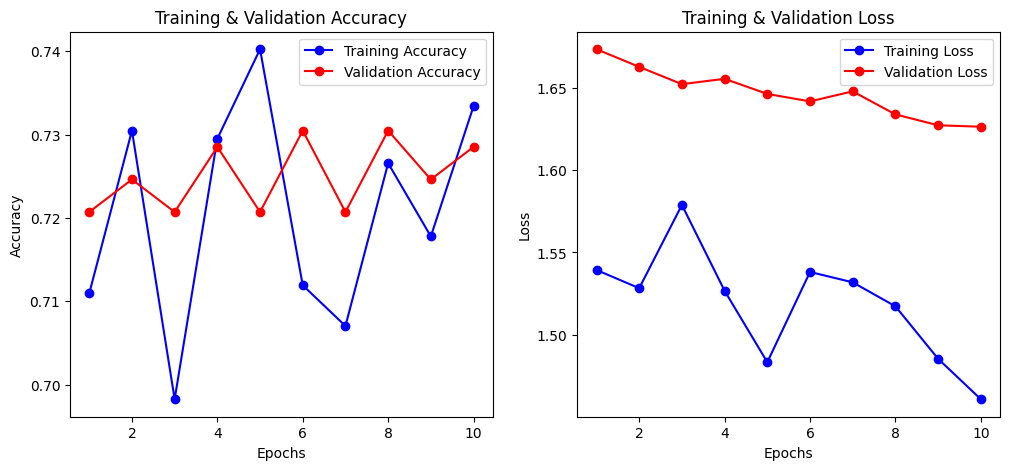

In [27]:
plot_training_curves(history_finetune)

### 4. Evalute the model:

#### 4.1 Get predictions on the test dataset:

In [28]:
y_pred_probs = model.predict(test_ds)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step


In [29]:
# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

#### 4.2 Compute metrics:

In [30]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

In [31]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7136
Precision: 0.7360
Recall: 0.7136
F1-Score: 0.7133


In [32]:
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.50      0.41        20
           1       0.90      0.90      0.90        40
           2       0.18      0.35      0.24        20
           3       0.48      0.28      0.35        36
           4       0.66      0.64      0.65        45
           5       1.00      0.88      0.94        25
           6       0.62      0.80      0.70        20
           7       0.76      1.00      0.87        65
           8       0.40      0.77      0.53        26
           9       0.71      0.88      0.79        25
          10       0.48      0.60      0.53        67
          11       0.92      0.73      0.82        67
          12       0.61      0.86      0.71        29
          13       0.60      0.93      0.73        28
          14       0.55      0.62      0.58        29
          15       0.27      0.48      0.34        21
          16       0.96      0.83      0.89        65
   

In [33]:
cm = confusion_matrix(y_true, y_pred)

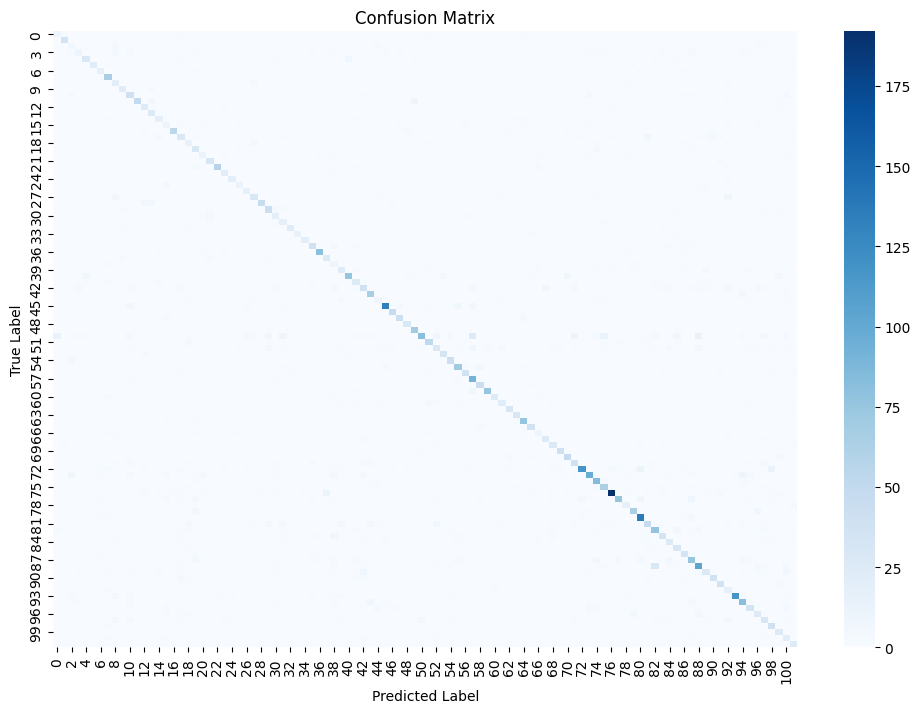

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()